In [106]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

%matplotlib inline

In [21]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

In [22]:
def save_torch_model(model, filename):
  if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))
  torch.save(model.state_dict(), filename)

def load_torch_model(model, filename):
  model.load_state_dict(torch.load(filename))


In [23]:
class ReplayMemory():
  def __init__(self, memory_size = 1000):
    self.transitions = []
    self.memory_size = memory_size
    self.loc_pointer = 0
  
  def clear(self):
    self.transitions = []
    self.loc_pointer = 0
  
  def add(self, step_tuple):
    # expect a tuple of transition contain:
    # state, action, reward, next_state, ended in order
    if len(self.transitions) <= self.loc_pointer:
      self.transitions.append(None)
    self.transitions[self.loc_pointer] = step_tuple
    self.loc_pointer += 1
    if self.loc_pointer >= self.memory_size:
      self.loc_pointer %= self.memory_size
  
  def get_sample(self, batch_size):
    return random.sample(self.transitions, batch_size)

In [33]:
class DQN(nn.Module):
  def __init__(self, output_size):
    super(DQN, self).__init__()
    self.l1_conv2d = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.l1_bn = nn.BatchNorm2d(16)
    self.l2_conv2d = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.l2_bn = nn.BatchNorm2d(32)
    self.l3_conv2d = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.l3_bn = nn.BatchNorm2d(32)
    self.l4_linear = nn.Linear(2240, output_size)
    
  def forward(self,x):
    out = F.relu(self.l1_bn(self.l1_conv2d(x)))
    out = F.relu(self.l2_bn(self.l2_conv2d(out)))
    out = F.relu(self.l3_bn(self.l3_conv2d(out)))
    out = self.l4_linear(out.view(out.size(0), -1))
    return out

In [34]:
def screen_to_tensor(raw_screen):
  # down sample, raw_screen from gym is Height x Width x Channel
  # taking every other pixel
  screen = raw_screen[::2,::2,::]
  
#   # to grayscale Y' = 0.299 R + 0.587 G + 0.114 B
#   screen = screen.dot([0.299,0.587,0.114])
  s = screen.transpose((2, 0, 1))
  t = FloatTensor(s)
  return t.unsqueeze(0)

def variable_to_screen(tensor):
  s = np.array(tensor.squeeze(0).data.tolist()).transpose((1,2,0))
  return s

In [91]:
class DQNAgent():
  def __init__(self, env):
    self._epsilon = 0.2
    self._gamma = 0.96
    self.env = env
    self.dqn = DQN(env.action_space.n)
    self.replay_memory = ReplayMemory()
    
  def epsilon(self):
    return self._epsilon
  
  def predict(self, state):
    return self.dqn(Variable(state)).data.tolist()[0]
  
  def pick_action(self, state):
    if (random.random() < self.epsilon()):
      action = self.env.action_space.sample()
    else:
      action = self.predict(state)
    return int(np.argmax(action))
  
  def update_Q(self, batch):
    # Q learning, Q(s,a) = Q(s,a) + alpha * [reward + gamma * max(Q(s')) - Q(s,a)]
    # Target of the Q function is the one step bellman equation "reward + gamma * max(Q(s'))"
    # so error is [taget - current estimation] = [reward + gamma * max(Q(s')) - Q(s,a)]
    (state, action, reward, next_state, ended) = tuple(zip(*batch))

    var_state = Variable(torch.cat(state))
    var_action = Variable(LongTensor(action))
    var_ended = FloatTensor(ended)
    var_reward = FloatTensor(reward)
    var_next_state = Variable(torch.cat(next_state))
    
    # current estimation, take the Q value of the action performed
    state_action_values = self.dqn(var_state).gather(1, var_action.view(-1,1))
    
    # target. If an episode ended at this step, only reward is used as there are no next state
    target_values = Variable(var_reward + (1 - var_ended) * self._gamma * self.dqn(var_next_state).max(1)[0])
    
    loss = F.mse_loss(state_action_values.view(-1), target_values)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
  
  def train(self, episode=5000, iter_per_episode=50, batch_size=32, lr=1e-3):
    self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr, weight_decay=1e-3)
    best_score = 0
    for i in range(episode):
      s0 = env.reset()
      state = screen_to_tensor(s0 - s0)
      episode_ended = False
      score = 0
      while not episode_ended:
        action = self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step(action)
        next_state = screen_to_tensor(s1-s0)
        if episode_ended:
          ended = 1
        else:
          ended = 0
        score += reward
        self.replay_memory.add((state,action,reward,next_state,ended))
        s0 = s1
        state = next_state
        if (len(self.replay_memory.transitions) > 10):
          break
        
      if (i + 1) % 100 == 0:
        if score > best_score:
          save_torch_model(self.Q, 'model/pytroch_dqn_best.pth')
          best_score = score
        save_torch_model(self.Q,'model/pytroch_dqn_iter_%d.pth' %(i+1))
        # longer the better, that mean the agent can keep the pole up for longer period
        print(i+1,': score:', score)
        
      if len(self.replay_memory.transitions) > batch_size:
        for j in range(iter_per_episode):
          batch = self.replay_memory.get_sample(batch_size)
          self.update_Q(batch)


In [92]:
env = gym.make('Pong-v0')

In [93]:
agent = DQNAgent(env)

In [95]:
agent.train(episode=1, iter_per_episode=1, batch_size=2)

TypeError: mul received an invalid combination of arguments - got (Variable), but expected one of:
 * (float value)
      didn't match because some of the arguments have invalid types: (!Variable!)
 * (torch.FloatTensor other)
      didn't match because some of the arguments have invalid types: (!Variable!)


In [95]:
def prepare_screen(raw_screen):
  # down sample, raw_screen from gym is Height x Width x Channel
  # taking every other pixel
  screen = raw_screen[::2,::2,::]
  
#   # to grayscale Y' = 0.299 R + 0.587 G + 0.114 B
#   screen = screen.dot([0.299,0.587,0.114])
  return screen

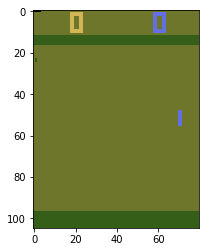

In [96]:
env = gym.make('Pong-v0')
s = env.reset()
s = prepare_screen(s)
plt.imshow(s)

In [97]:
dqn = DQN(env.action_space.n)

In [109]:
s_list = [screen_to_variable(s),screen_to_variable(s),screen_to_variable(s),screen_to_variable(s)]

(53, 40, 3)
(3, 53, 40)
(53, 40, 3)
(3, 53, 40)
(53, 40, 3)
(3, 53, 40)
(53, 40, 3)
(3, 53, 40)


In [100]:
v = screen_to_variable(s)
v_in = v.unsqueeze(0)
print(v_in.shape)
dqn(v_in)

torch.Size([1, 3, 105, 80])


Variable containing:
-0.0164  0.0436 -0.4002  0.2036 -0.1353 -0.1481
[torch.FloatTensor of size 1x6]

In [29]:
s.shape

(210, 160, 3)

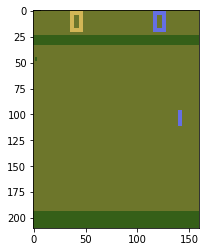

In [30]:
plt.imshow(s)

In [23]:
s1 =s[::2,::2,::]

In [25]:
s1.shape

(105, 80, 3)

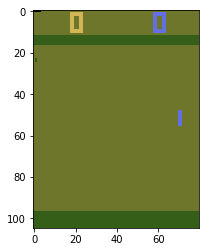

In [28]:
plt.imshow(s1)

In [21]:
s2 = s1.dot([0.299,0.587,0.114])

In [31]:
s2.shape

(105, 80)

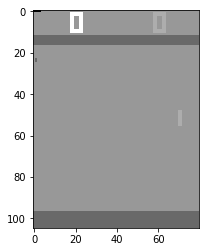

In [138]:
plt.imshow(s2, cmap = plt.get_cmap('gray'))

In [4]:
l[0::10]

range(0, 165, 10)

In [12]:
env = gym.make('Pong-v0')
env.reset()
img = env.render(mode='rgb_array')
img.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(FloatTensor)

In [8]:
dqn = DQN(6)

In [9]:
dqn(get_screen())

AttributeError: 'NoneType' object has no attribute 'transpose'

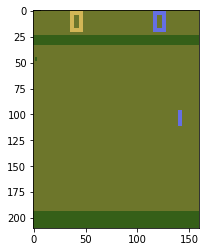

In [11]:
img = plt.imshow(env.render(mode='rgb_array')) # only call this once


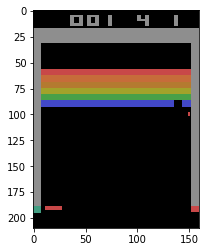

In [2]:
env = gym.make('Breakout-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

KeyboardInterrupt: 

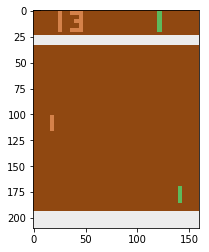

In [97]:
env = gym.make('Pong-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
e = False
while e == False:
  img.set_data(env.render(mode='rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  (s,r,e,i) = env.step(action)

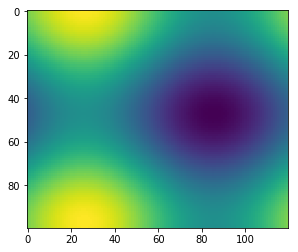

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50)
plt.show()

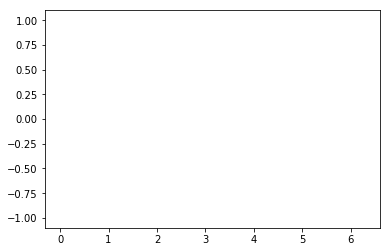

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()

In [125]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
  
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
  
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

In [137]:
frames = []
env = gym.make('Breakout-v0')
rgb_array = env.reset()
frames.append(rgb_array)
for _ in range(100):
  action = env.action_space.sample()
  rgb_array = env.step(action)
  frames.append(rgb_array)

Traceback (most recent call last):
  File "/Users/ju/anaconda2/envs/pytorch36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/ju/anaconda2/envs/pytorch36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/ju/anaconda2/envs/pytorch36/lib/python3.6/site-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/Users/ju/anaconda2/envs/pytorch36/lib/python3.6/site-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/ju/anaconda2/envs/pytorch36/lib/python3.6/site-packages/matplotlib/animation.py", line 1814, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
TypeError: 'list' object is not callable


TypeError: 'list' object is not callable

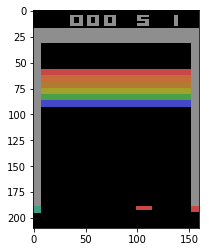

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

count = 0
def f(x, y):
    global count
    count += 1
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(frames[0], animated=True)

def updatefig(*args):
    global count

    global x, y
    count += 1
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_data(frames[count])
#     im.set_array(f(x, y))
    return im,
ims = []
for i in range(len(frames)):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

anim = animation.FuncAnimation(fig, ims, interval=50, blit=True)
HTML(anim.to_html5_video())

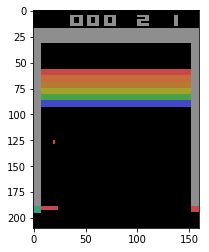

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

frames = []
env = gym.make('Breakout-v0')
rgb_array = env.reset()
frames.append(rgb_array)
for _ in range(100):
  action = env.action_space.sample()
  env.step(action)
  rgb_array = env.render(mode='rgb_array')
  frames.append(rgb_array)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(len(frames)):
    x += np.pi / 15.
    y += np.pi / 20.
#     im = plt.imshow(f(x, y), animated=True)
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

HTML(ani.to_html5_video())

In [144]:
print(frames)

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...

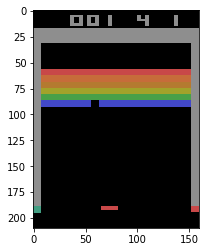

In [5]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

env = gym.make('Breakout-v0')
env.reset()
frames = []
frames.append(env.render(mode='rgb_array'))
for _ in range(100):
  action = env.action_space.sample()
  env.step(action)
  frames.append(env.render(mode='rgb_array'))

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
def animate(frames):
  fig = plt.figure()

  ims = []
  for i in range(len(frames)):
      im = plt.imshow(frames[i], animated=True)
      ims.append([im])
  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
  return ani

HTML(animate(frames).to_html5_video())


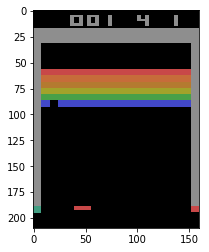

In [4]:
animate(frames)

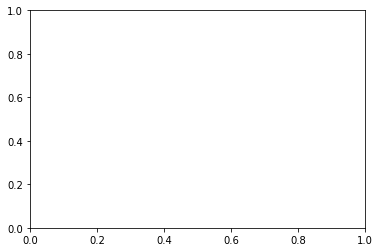

In [6]:
fig, ax = plt.subplots()

In [7]:
ax

In [8]:
fig,ax = plt.figure()

TypeError: 'Figure' object is not iterable